In [25]:
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()
[x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']


['device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0',
 'device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1c:00.0, compute capability: 7.0',
 'device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1d:00.0, compute capability: 7.0',
 'device: 3, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1e:00.0, compute capability: 7.0']

## Препроцессинг

In [26]:
from glob import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [27]:

images = []
diseases = []
for culture in glob("dataset/*"):
    for disease in glob(culture+"/*"):
        for s in glob(disease+"/*"):
            img = img_to_array(load_img(s, target_size=(224,224))) 
            diseases.append(culture.split('/')[-1]+"-"+disease.split('/')[-1])
            images.append(img)
len(diseases), len(images)

(934, 934)

In [28]:
len(diseases)

934

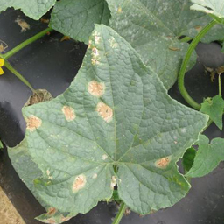

In [29]:
array_to_img(images[0])

In [30]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

de = LabelEncoder()
n_labels = de.fit_transform(diseases)
D = to_categorical(n_labels)

In [31]:
labels_count = np.unique(n_labels).size
labels_count

25

In [32]:
from tensorflow.keras.applications.nasnet import preprocess_input
X = preprocess_input(np.array(images))

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, C_train, C_test = train_test_split(X, D, train_size=0.8, test_size=0.2, random_state=777) # поменял на исходные изображения

In [34]:
gen_train = ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    horizontal_flip=True)
flow_train = gen_train.flow(X_train,C_train)

gen_test = ImageDataGenerator()
flow_test = gen_test.flow(X_test, C_test)

## Обучение

In [35]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D
import tensorflow as tf

In [36]:
restnet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3)) # загружаем предобученную сеть

output = restnet.layers[-1].output # используем выход пердыдущего слоя
restnet_output = Model(restnet.input, outputs=[output]) # создаем это все дело как модель
for layer in restnet.layers: # замораживаем предобученные слои модели
    layer.trainable = False


In [37]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Input, concatenate 
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

#C_input = Input(shape=(C.shape[1]))

conv = Conv2D(600, (5,5))(restnet_output.output)
res_pooling = MaxPooling2D((3,3))(conv)
flat = Flatten()(res_pooling)

#concat_l = concatenate([C_input, flat])

dense_1 = Dense(128, activation='sigmoid')(flat)
drop_1 = Dropout(0.3)(dense_1)
dense_3 = Dense(labels_count, activation='sigmoid')(drop_1)

model = Model(inputs=[restnet_output.input], outputs=[dense_3])
model.compile(loss='categorical_crossentropy', # лейблы кодируются в one-hot
                  optimizer=optimizers.RMSprop(lr=2e-5), # sgd с тюнингом
                  metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [38]:
model.input

<tf.Tensor 'input_2:0' shape=(None, 224, 224, 3) dtype=float32>

In [39]:
X_train.shape

(747, 224, 224, 3)

In [100]:
import datetime
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint.ch",
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(flow_train,
                    steps_per_epoch=200,
                    epochs=20,
                    validation_steps=30,
                    validation_data=flow_test,
                    verbose=1)

/opt/anaconda3/envs/myenv2/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/anaconda3/envs/myenv2/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
200/200 [==============================] - 62s 310ms/step - loss: 1.1251 - accuracy: 0.9780 - val_loss: 1.4848 - val_accuracy: 0.7497
Epoch 2/20
200/200 [==============================] - 65s 324ms/step - loss: 1.0348 - accuracy: 0.9797 - val_loss: 1.4201 - val_accuracy: 0.7455
Epoch 3/20
200/200 [==============================] - 68s 339ms/step - loss: 0.9301 - accuracy: 0.9844 - val_loss: 1.3434 - val_accuracy: 0.7540
Epoch 4/20
200/200 [==============================] - 66s 332ms/step - loss: 0.8415 - accuracy: 0.9868 - val_loss: 1.3283 - val_accuracy: 0.7422
Epoch 5/20
200/200 [==============================] - 59s 294ms/step - loss: 0.7591 - accuracy: 0.9902 - val_loss: 1.2810 - val_accuracy: 0.7422
Epoch 6/20
200/200 [==============================] - 63s 315ms/step - loss: 0.6843 - accuracy: 0.9929 - val_loss: 1.2427 - val_accuracy: 0.7380
Epoch 7/20
200/200 [==============================] - 65s 325ms/step - loss: 0.6172 - accuracy: 0.9936 - val_loss: 1.2049 - val_ac

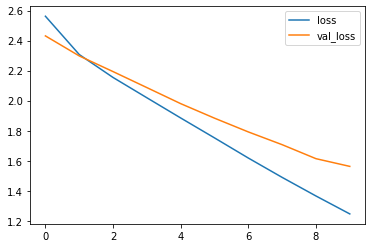

In [43]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss","val_loss"])

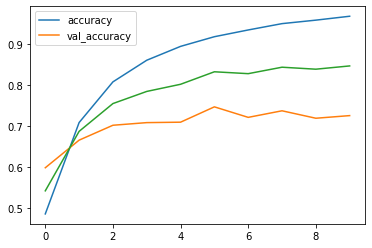

In [44]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot((np.array(history.history["val_accuracy"])+np.array(history.history["accuracy"]))/2)
plt.legend(["accuracy","val_accuracy"])

In [45]:
def predict(n):
    img = preprocess_input(np.array([images[n]]))
    predicted = np.argmax(model.predict(img))
    plt.imshow(images[n].astype("int"))
    actual = np.argmax(D[n])
    return de.inverse_transform([predicted, actual])

In [46]:
def find_failed():
    transformed = preprocess_input(np.array(images))
    predicted = model.predict(transformed)
    for i in range(predicted.shape[0]):
        p = np.argmax(predicted[i])
        a = np.argmax(D[i])
        if(p!=a):
            print((i, de.inverse_transform([p,a])))

In [99]:
print("id, predicted, actual")
find_failed()

id, predicted, actual
(8, array(['Grape-Black rot', 'Cucumbers-Anthracnose'], dtype='<U29'))
(20, array(['Grape-Healthy', 'Cucumbers-Anthracnose'], dtype='<U29'))
(21, array(['Grape-Healthy', 'Cucumbers-Anthracnose'], dtype='<U29'))
(38, array(['Cucumbers-Nutrient deficiency', 'Cucumbers-Healthy'], dtype='<U29'))
(42, array(['Cucumbers-Nutrient deficiency', 'Cucumbers-Healthy'], dtype='<U29'))
(43, array(['Grape-Healthy', 'Cucumbers-Healthy'], dtype='<U29'))
(48, array(['Grape-Healthy', 'Cucumbers-Healthy'], dtype='<U29'))
(52, array(['Grape-Healthy', 'Cucumbers-Healthy'], dtype='<U29'))
(58, array(['Cucumbers-Nutrient deficiency', 'Cucumbers-Healthy'], dtype='<U29'))
(73, array(['Cucumbers-Powdery mildew', 'Cucumbers-Downy mildew'], dtype='<U29'))
(75, array(['Cucumbers-Anthracnose', 'Cucumbers-Downy mildew'], dtype='<U29'))
(93, array(['Cucumbers-Nutrient deficiency', 'Cucumbers-Downy mildew'],
      dtype='<U29'))
(97, array(['Cucumbers-Anthracnose', 'Cucumbers-Downy mildew'], dtype

In [70]:
def get_by_name(name):
    return list(filter(lambda x: x[1] == name, enumerate(diseases)))

In [73]:
get_by_name('Cotton-Healthy')[0][0]

780

In [96]:
def draw(id):
    plt.figure()
    plt.title(diseases[id])
    plt.imshow(images[id].astype("int"))

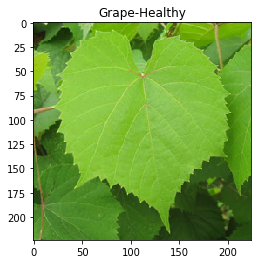

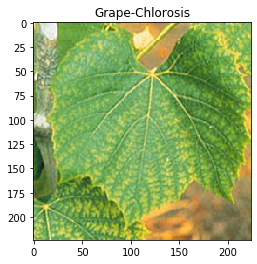

In [98]:
draw(get_by_name('Grape-Healthy')[1][0])
draw(get_by_name('Grape-Chlorosis')[1][0])